In [1]:
import vaex
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from os.path import join, abspath
import sys
from os import pardir, mkdir

In [2]:
# import utils
util_dir = abspath(pardir)
sys.path.insert(0, util_dir)

from utils import load_spectral_types, main_sequence_cut_r, main_locus

In [2]:
root_data_dir = abspath(join(pardir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [3]:
name = "Spectral-Class"
data_dir = join(root_data_dir, name)
try:
  mkdir(data_dir)
  print(f"Creating {name} dir in Data dir")
except FileExistsError:
  print("Directory already exist. Good to go!")

Creating Spectral-Class dir in Data dir


In [4]:
# path to file produced by 1.1. Gaia DR3 and 2MASS.ipynb
gaia_dir = join(root_data_dir, "Gaia-2MASS")
files = glob(join(gaia_dir, "*.hdf5"))
# file = join(data_dir, "mamajek-spectral-class.hdf5")
files[:5]

['/home2/s20321005/Thesis-Project/Data/Gaia-2MASS/gaia-219-220.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Gaia-2MASS/gaia-079-080.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Gaia-2MASS/gaia-218-219.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Gaia-2MASS/gaia-182-183.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Gaia-2MASS/gaia-045-046.hdf5']

In [5]:
gaia_raw = vaex.open_many(files)
gaia_raw

#,source_id,ra,dec,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,Gmag,BPmag,RPmag,rv_gaia,e_rv_gaia,bp_rp,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,RAVE6,SDSS13,Jmag,Hmag,Kmag,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs
0,5764635079544432128,219.77805455719,-89.56922832436,7.511,1.522,0.021,-7.355,0.020949371,2.8775,0.0184,10.847249,11.118501,10.412085,-5.29,0.73,0.706416,303.15029042357,-26.74401558194,6141.6,6130.1,6152.1,4.043,4.0398,4.0469,-0.4365,-0.4457,-0.4269,344.0585,341.9788,346.0511,0.0799,0.0745,0.0847,,--,9.953,9.698,9.683,-0.26,-0.32,-0.22,0.33,0.26,0.4,nan,nan,nan,F
1,5764635393079767296,219.15195997564,-89.5318109641,11.203,-8.352,0.012,-7.467,0.012214055,0.4305,0.011,13.174702,13.789571,12.425439,67.09,0.91,1.364132,303.16401990137,-26.70832039314,4718.7,4713.3,4724.8,2.5833,2.5655,2.6014,-0.1946,-0.1952,-0.1941,2070.6995,2031.6134,2112.0928,0.3619,0.3574,0.3668,,--,11.418,10.819,10.704,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
2,5764635496158988544,219.83101507284,-89.50979783241,2.65,-2.095,0.022,1.623,0.024982337,0.2155,0.0218,14.993793,15.584641,14.263248,nan,nan,1.321393,303.18075914642,-26.69113646047,4881.6,4875.7,4888.8,3.0708,3.0509,3.0862,-0.1415,-0.15,-0.1356,3446.1995,3376.546,3517.8865,0.4145,0.4093,0.4207,,--,13.306,12.725,12.634,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
3,5764638554175708672,219.24632619569,-89.48870252979,11.672,-10.811,0.017,-4.399,0.01951931,1.9675,0.0166,14.446186,14.915824,13.815229,13.17,3.9,1.100595,303.18615009602,-26.66999019517,5226.6,5217.9,5235.5,4.5456,4.5418,4.5518,-0.1967,-0.2063,-0.1864,490.8246,487.5747,493.967,0.2623,0.2565,0.2679,,--,13.026,12.587,12.512,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
4,5764639241370488064,219.24010479539,-89.44765029195,14.783,-10.759,0.113,-10.139,0.12553297,1.2643,0.1066,17.817894,18.871086,16.80843,nan,nan,2.062656,303.2064053892,-26.63317348591,4119.2,4089.7,4135.9,4.6477,4.6411,4.6547,0.3467,0.2681,0.3855,822.1085,799.1945,831.1044,0.7264,0.6964,0.7513,,--,15.434,14.768,14.468,nan,nan,nan,nan,nan,nan,nan,nan,nan,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"94,994,937",576406227696244864,33.65804765403,89.33197663578,4.686,-4.139,0.072,-2.197,0.064973824,0.6416,0.0561,16.92992,17.625141,16.097548,nan,nan,1.527594,123.19695964994,26.50349463792,4337.4,4217.8,4422.2,4.3911,4.2846,4.4237,-0.3812,-0.4888,-0.3243,1117.2708,1065.5874,1205.549,0.305,0.1938,0.3925,,--,14.993,14.263,14.201,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
"94,994,938",576431585183142528,33.61268607589,89.48206639541,1.894,-1.763,0.02,0.693,0.017867079,0.6989,0.0159,14.399571,15.067607,13.604876,-14.88,3.59,1.462731,123.13723815775,26.64377331058,5178.8,5133.0,5367.7,3.5746,3.4492,3.8413,-0.4349,-0.4827,-0.291,1165.2085,893.3535,1341.377,0.9013,0.8756,0.9909,,--,12.616,12.051,11.924,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
"94,994,939",576445638316125184,33.60957894134,89.57301292445,4.728,-2.691,0.018,3.887,0.015934618,0.7782,0.015,14.292352,14.78063,13.633098,-36.36,7.38,1.147533,123.10127650839,26.72887005884,5855.7,5835.1,5878.4,4.0048,3.9971,4.0145,-0.583,-0.6066,-0.555,1217.041,1196.2493,1234.8632,0.7542,0.7434,0.7665,,--,12.857,12.457,12.404,nan,nan,nan,nan,nan,nan,nan,nan,nan,G
"94,994,940",576447459382243200,33.57768719537,89.70251709954,17.162,10.764,0.021,13.367,0.021056626,0.9942,0.0197,14.856944,15.333351,14.206361,-6.87,13.13,1.12699,123.04990412536,26.85002805556,5420.3,5395.1,5501.3,4.2236,4.2103,4.2407,-1.28,-1.323,-1.1485,946.7403,929.4686,962.1341,0.4847,0.4702,0.5

In [6]:
cols = ["parallax", "Jmag", "Kmag", "spectraltype_esphs", "GLON", "GLAT"]
gaia = gaia_raw[cols]
gaia["J-K"] = gaia["Jmag"] - gaia["Kmag"]
gaia["M_J"] = gaia["Jmag"] -10 - 5*np.log10(1/gaia["parallax"])
gaia

#,parallax,Jmag,Kmag,spectraltype_esphs,GLON,GLAT,J-K,M_J
0,2.8775,9.953,9.683,F,303.15029042357,-26.74401558194,0.27000046,2.248076730173698
1,0.4305,11.418,10.704,K,303.16401990137,-26.70832039314,0.71399975,-0.41213399979919085
2,0.2155,13.306,12.634,K,303.18075914642,-26.69113646047,0.67199993,-0.026763871656873217
3,1.9675,13.026,12.512,K,303.18615009602,-26.66999019517,0.51399994,4.495573728043695
4,1.2643,15.434,14.468,,303.2064053892,-26.63317348591,0.9659996,5.943250704949416
...,...,...,...,...,...,...,...,...
"94,994,937",0.6416,14.993,14.201,K,123.19695964994,26.50349463792,0.7919998,4.029321806898113
"94,994,938",0.6989,12.616,11.924,K,123.13723815775,26.64377331058,0.6920004,1.8380753778451964
"94,994,939",0.7782,12.857,12.404,G,123.10127650839,26.72887005884,0.45300007,2.312456483290767
"94,994,940",0.9942,13.478,12.953,G,123.04990412536,26.85002805556,0.5249996,3.465368481209726


In [39]:
df_mask = gaia.filter(1/gaia.parallax < 0.25)
df_mask = df_mask.extract()
df_mask

#,parallax,Jmag,Kmag,spectraltype_esphs,GLON,GLAT,J-K,M_J
0,4.8856,15.495,14.439,,303.31948017862,-26.45025773519,1.0559998,8.939589420498129
1,4.4942,15.405,14.514,,303.38324748783,-26.31746560361,0.8909998,8.668261709972928
2,5.2098,13.218,12.394,M,304.21349143516,-24.84265760807,0.82400036,6.802105669018919
3,4.189,10.441,10.037,G,304.35918536893,-24.56578314913,0.40400028,3.551551786547308
4,6.6145,14.604,13.835,M,304.3605357767,-24.49310019103,0.76900005,8.706485195509723
...,...,...,...,...,...,...,...,...
"2,320,855",4.4498,12.04,11.304,K,123.9179787582,24.75120393563,0.73600006,5.281702420298894
"2,320,856",6.0812,14.569,13.802,,123.73586955146,25.16264104675,0.7670002,8.488946678296603
"2,320,857",4.5317,14.866,14.057,,123.59191069412,25.58058293335,0.809,8.147305934017778
"2,320,858",5.1215,13.236,12.439,M,123.53336721783,25.6892916472,0.79699993,6.782985946300498


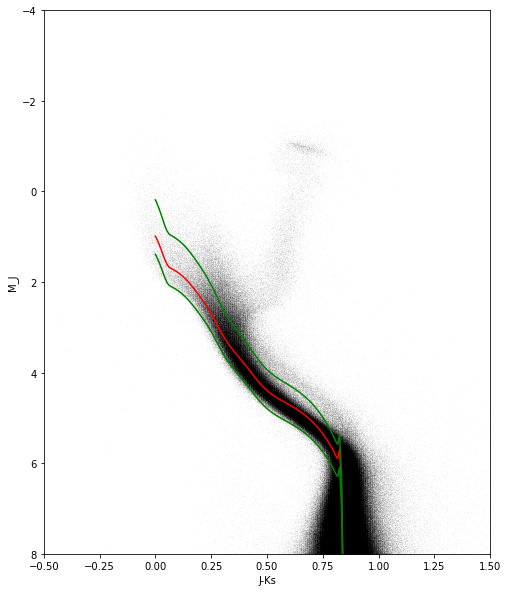

In [34]:
# HR diagram
JK = np.linspace(0, 0.86, 100)
MJ = main_locus(JK)
MJ_high = main_sequence_cut_r(JK)
MJ_low = main_sequence_cut_r(JK, low=True)
plt.figure(figsize=(8,10))
df_mask.viz.scatter("J-K", "M_J", c='k', alpha=0.1, s=0.01, length_check=False)
plt.plot(JK, MJ, c="red")
plt.plot(JK, MJ_low, c="green")
plt.plot(JK, MJ_high, c="green")
plt.xlabel("J-Ks")
plt.ylabel("M_J")
plt.xlim(-0.5, 1.5)
plt.ylim(-4, 8)
plt.gca().invert_yaxis()
plt.show()

In [35]:
df_s = load_spectral_types()
df_s

,SpT,M_J,J-H,H-Ks,J-K
0,O9V,-3.44,-0.164,-0.071,-0.235
1,O9.5V,-3.30,-0.161,-0.069,-0.230
2,B0V,-3.17,-0.159,-0.067,-0.226
3,B0.5V,-2.80,-0.153,-0.063,-0.216
4,B1V,-2.33,-0.148,-0.059,-0.207
...,...,...,...,...,...
95,T6V,15.34,0.100,-0.030,0.070
96,T7V,15.83,0.000,0.000,0.000
97,T7.5V,16.61,0.200,-0.050,0.150
98,T8V,17.30,0.200,-0.050,0.150


In [40]:
df_mask['M_J_upper'] = main_sequence_cut_r(df_mask['J-K'].to_numpy())
df_mask['M_J_lower'] = main_sequence_cut_r(df_mask['J-K'].to_numpy(), low=True)
df_mask

#,parallax,Jmag,Kmag,spectraltype_esphs,GLON,GLAT,J-K,M_J,M_J_upper,M_J_lower
0,4.8856,15.495,14.439,,303.31948017862,-26.45025773519,1.0559998,8.939589420498129,10.043211255081008,10.348373868255463
1,4.4942,15.405,14.514,,303.38324748783,-26.31746560361,0.8909998,8.668261709972928,9.18049264093229,9.564084219029354
2,5.2098,13.218,12.394,M,304.21349143516,-24.84265760807,0.82400036,6.802105669018919,5.369069622770682,6.099154202518802
3,4.189,10.441,10.037,G,304.35918536893,-24.56578314913,0.40400028,3.551551786547308,3.3230369180110393,4.239124470919127
4,6.6145,14.604,13.835,M,304.3605357767,-24.49310019103,0.76900005,8.706485195509723,5.136395144099251,5.887631949181138
...,...,...,...,...,...,...,...,...,...,...
"2,320,855",4.4498,12.04,11.304,K,123.9179787582,24.75120393563,0.73600006,5.281702420298894,4.889435174426507,5.663122885842279
"2,320,856",6.0812,14.569,13.802,,123.73586955146,25.16264104675,0.7670002,8.488946678296603,5.119852890151631,5.872593536501483
"2,320,857",4.5317,14.866,14.057,,123.59191069412,25.58058293335,0.809,8.147305934017778,5.533743842329893,6.248858038481721
"2,320,858",5.1215,13.236,12.439,M,123.53336721783,25.6892916472,0.79699993,6.782985946300498,5.394523147775026,6.1222937707045695


In [41]:
# Filter A star
JK_lower = (df_s[df_s['SpT'] == 'B9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'A0V']['J-K'].to_numpy()[0])/2
JK_upper = (df_s[df_s['SpT'] == 'A9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'F0V']['J-K'].to_numpy()[0])/2

mask_A = ((df_mask['J-K'] > JK_lower)
          *(df_mask['J-K'] < JK_upper)
          *(df_mask['M_J_lower'] > df_mask['M_J'])
          *(df_mask['M_J_upper'] < df_mask['M_J']))
df_A = df_mask[mask_A]
df_A

#,parallax,Jmag,Kmag,spectraltype_esphs,GLON,GLAT,J-K,M_J,M_J_upper,M_J_lower
0,5.872,8.341,8.224,A,317.83929176982,4.88022843372,0.116999626,2.1849298378115547,1.1369589028943679,2.2517808208130616
1,4.757,8.377,8.311,A,325.27502603111,20.34845584874,0.065999985,1.7636656121410121,0.958875432568412,2.0898867568803747
2,4.5387,8.855,8.734,F,329.98650867054,28.47255594101,0.120999336,2.13965693022862,1.1554230387838285,2.2685663988943894
3,4.1436,8.328,8.271,A,335.90312493356,38.048697291,0.05700016,1.4148891906499461,0.9168398444757582,2.051672585887053
4,5.9392,6.778,6.789,A,8.09579105058,61.55463071494,-0.011000156,0.6466396289434337,0.06500256027271278,1.2772750547933753
...,...,...,...,...,...,...,...,...,...,...
"5,606",4.1018,8.566,8.487,A,134.75223663738,-6.05897456768,0.07899952,1.6308723884842182,0.995979379254096,2.1236176175037236
"5,607",8.0034,7.472,7.342,A,133.35348014811,-2.40989433775,0.13000011,1.98837273674852,1.1999704839358463,2.3090640763053147
"5,608",5.3099,7.665,7.614,A,133.51088678403,-1.89332501134,0.05100012,1.2904316728562906,0.8638846684989678,2.0035315168172434
"5,609",5.1138,8.209,8.14,A,127.31472682222,15.73875737031,0.06899929,1.7527183279202725,0.9672667827555868,2.0975152570505333


In [44]:
df_A.export(join(data_dir, "A-type.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :    22.92s =  0.4m =  0.0h
 

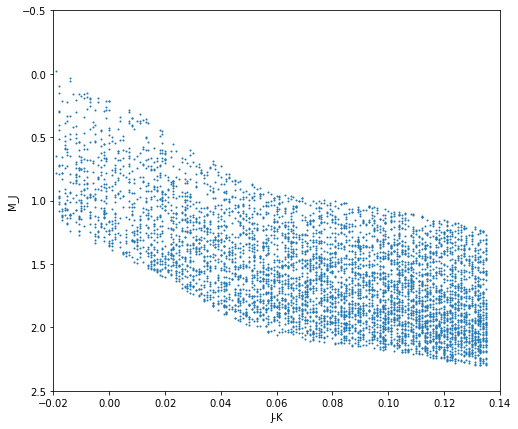

In [45]:
# HR diagram for gaia filter
plt.figure(figsize=(8,7))
# df_mask.plot("bp_rp", "Gmag -10 - 5*log10(1/parallax)", what=vaex.stat.count(), limits='95%')
df_A.viz.scatter("J-K", "M_J", s=1, length_limit=500_000)
# df_A2.viz.scatter("J-K", "M_J", s=2, length_limit=500_000)
plt.xlabel("J-K")
plt.ylabel("M_J")
plt.xlim(-0.02, 0.14)
plt.ylim(-0.5, 2.5)
plt.gca().invert_yaxis()
plt.show()

In [46]:
# Filter F star
JK_lower = (df_s[df_s['SpT'] == 'A9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'F0V']['J-K'].to_numpy()[0])/2
JK_upper = (df_s[df_s['SpT'] == 'F9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'G0V']['J-K'].to_numpy()[0])/2

mask_F = ((df_mask['J-K'] > JK_lower)
          *(df_mask['J-K'] < JK_upper)
          *(df_mask['M_J_lower'] > df_mask['M_J'])
          *(df_mask['M_J_upper'] < df_mask['M_J']))
df_F = df_mask[mask_F]
df_F

#,parallax,Jmag,Kmag,spectraltype_esphs,GLON,GLAT,J-K,M_J,M_J_upper,M_J_lower
0,10.0035,7.983,7.709,F,308.70305810499,-15.96274140912,0.2739997,2.9837596840074134,2.3089693103140805,3.317244827558255
1,4.6832,9.056,8.848,F,309.85705005232,-13.61659868064,0.20800018,2.4087132813079584,1.7166278087127917,2.778752553375265
2,4.053,9.361,9.178,F,309.99358590909,-13.06589189025,0.18299961,2.3998830797436215,1.5342488210961178,2.6129534737237434
3,4.5494,9.669,9.356,F,311.59451409248,-9.28876051119,0.31299973,2.958770288329803,2.6891500269949327,3.6628636609044842
4,5.5365,9.387,9.089,G,313.08769653991,-6.07617303119,0.29800034,3.103176605180032,2.553404068387847,3.5394582439889515
...,...,...,...,...,...,...,...,...,...,...
"44,831",7.2937,8.867,8.582,F,130.4080282895,6.32233258131,0.28499985,3.1817391072124472,2.423400630749501,3.4212733006813645
"44,832",5.3317,9.426,9.156,F,130.24122835792,7.10215540541,0.2699995,3.0603281658233783,2.267292458456026,3.279356780414569
"44,833",5.6949,8.932,8.697,F,129.23893643885,9.97484538744,0.23500061,2.7094306725040402,1.9330298044903271,2.975481640445752
"44,834",5.8219,9.173,8.866,F,128.19341239923,13.04693932097,0.30700016,2.998324043181579,2.6367834035756075,3.6152576396141884


In [47]:
df_F.export(join(data_dir, "F-type.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :    11.65s =  0.2m =  0.0h
 

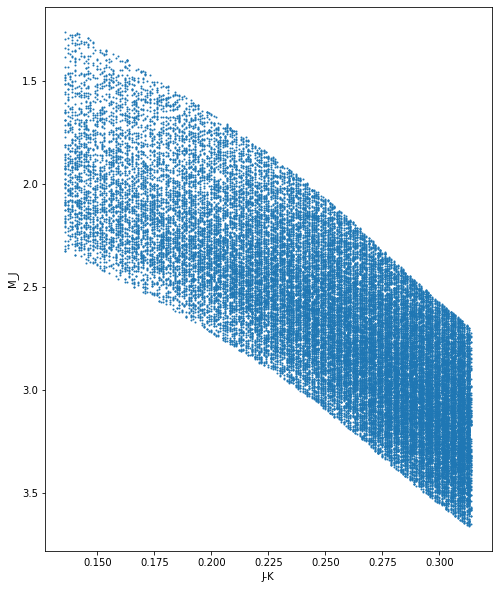

In [48]:
# HR diagram
plt.figure(figsize=(8,10))
df_F.viz.scatter("J-K", "M_J", s=1, length_limit=500_000)
plt.xlabel("J-K")
plt.ylabel("M_J")
# plt.xlim(-0, 3)
# plt.ylim(0, 12)
plt.gca().invert_yaxis()
plt.show()

In [49]:
# Filter G star
JK_lower = (df_s[df_s['SpT'] == 'F9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'G0V']['J-K'].to_numpy()[0])/2
JK_upper = (df_s[df_s['SpT'] == 'G3V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'G4V']['J-K'].to_numpy()[0])/2

mask_G = ((df_mask['J-K'] > JK_lower)
          *(df_mask['J-K'] < JK_upper)
          *(df_mask['M_J_lower'] > df_mask['M_J'])
          *(df_mask['M_J_upper'] < df_mask['M_J']))
df_G = df_mask[mask_G]
df_G

#,parallax,Jmag,Kmag,spectraltype_esphs,GLON,GLAT,J-K,M_J,M_J_upper,M_J_lower
0,10.4109,7.971,7.617,G,309.20829299388,-14.62239998145,0.3540001,3.058441569354164,2.996022447317366,3.9418385884703326
1,5.1551,10.003,9.657,F,309.98946985028,-13.24784883922,0.34600067,3.5641857307046174,2.941428428120238,3.8922076619274892
2,4.0595,10.269,9.905,G,311.48707339392,-9.5727177916,0.36400032,3.311362782112933,3.062194607771028,4.001995097973662
3,7.7619,9.075,8.72,G,313.64855778948,-4.74528210705,0.35499954,3.5248400254232584,3.0027262475877885,3.947932952352535
4,6.0806,9.229,8.909,G,313.35519580106,-5.77254938506,0.3199997,3.1487322673839953,2.7473274369165597,3.7157522153786906
...,...,...,...,...,...,...,...,...,...,...
"44,040",9.3059,8.7,8.345,G,131.79358483802,2.02380394586,0.35499954,3.543791716014579,3.0027262475877885,3.947932952352535
"44,041",4.6498,10.258,9.892,G,129.05535554237,10.38004631137,0.36600018,3.595171739618739,3.0752304736451737,4.0138458851319765
"44,042",4.2048,9.812,9.489,F,128.92631250059,11.10975102299,0.32299995,2.930726992376542,2.771379325968671,3.7376175690624285
"44,043",4.7746,10.273,9.925,G,127.45426274676,15.15891959779,0.34799957,3.6676847320202595,2.9552406447770223,3.9047642225245656


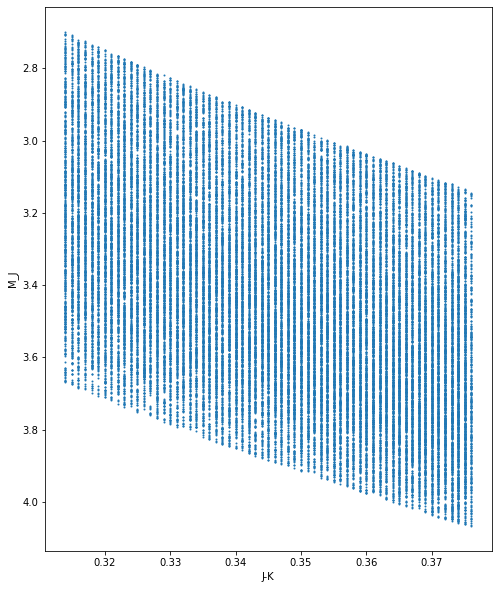

In [50]:
# HR diagram for gaia filter
plt.figure(figsize=(8,10))
df_G.viz.scatter("J-K", "M_J", s=1, length_limit=500_000)
plt.xlabel("J-K")
plt.ylabel("M_J")
# plt.xlim(-0, 3)
# plt.ylim(0, 12)
plt.gca().invert_yaxis()
plt.show()

In [51]:
df_G.export(join(data_dir, "G-type.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :    11.39s =  0.2m =  0.0h
 